In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import bbknn
import scvelo as scv
import anndata
import leidenalg
import loompy
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
from matplotlib.pyplot import rc_context
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import random
import mellon

In [2]:
import scanpy as sc
import anndata
import os

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# Define sample paths
sample_paths = {
    "YSham_GFP": "YSham_GFP_adata_filtered_with_SOLO.h5ad",
    "YSham_noGFP": "YSham_noGFP_adata_filtered_with_SOLO.h5ad",
    "YOV_GFP": "YOV_GFP_adata_filtered_with_SOLO.h5ad",
    "YOV_noGFP": "YOV_noGFP_adata_filtered_with_SOLO.h5ad",
    "ASham_GFP": "ASham_GFP_adata_filtered_with_SOLO.h5ad",
    "ASham_noGFP": "ASham_noGFP_adata_filtered_with_SOLO.h5ad",
    "AOV_GFP": "AOV_GFP_adata_filtered_with_SOLO.h5ad",
    "AOV_noGFP": "AOV_noGFP_adata_filtered_with_SOLO.h5ad"
}

samples = list(sample_paths.keys())  # Get sample names

# Load each sample
adata = []
for sample in samples:
    adata.append(sc.read_h5ad(sample_paths[sample]))

# Concatenate the AnnData objects
adata_concat = anndata.AnnData.concatenate(
    adata[0], adata[1], adata[2], adata[3], 
    adata[4], adata[5], adata[6], adata[7], 
    batch_categories=samples
)

# Add the 'Sample' column to `adata_concat.obs` based on the 'batch' information
adata_concat.obs['Sample'] = adata_concat.obs['batch']

# Save the concatenated dataset
adata_concat.write("adata_concat.h5ad")

# Check the count of observations grouped by 'Sample'
print(adata_concat.obs.groupby('Sample').count())

# Make a copy of the concatenated AnnData object for further processing
adata = adata_concat.copy()

# Filter out cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_genes=200)

# Filter out genes that are detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Identify hemoglobin genes, excluding those starting with "HbP"
adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)

# Remove hemoglobin genes (keep only genes where 'hb' is False)
adata = adata[:, ~adata.var['hb']]

# Identify mitochondrial genes (those starting with 'mt-')
adata.var['mt'] = adata.var_names.str.startswith('mt-')

# Calculate QC metrics including mitochondrial gene content
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells based on mitochondrial content and gene count
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Save the raw counts for later analysis
adata.layers['counts'] = adata.X.copy()

# Normalize total counts to 10,000 per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Save the raw data before filtering highly variable genes
adata.raw = adata

# Subset the data to keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Regress out unwanted variables like total counts, number of genes, and mitochondrial content
sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])

# Scale the data
sc.pp.scale(adata, max_value=10)

# Perform PCA
sc.tl.pca(adata)


             batch  doublet
Sample                     
YSham_GFP     2512     2512
YSham_noGFP   7577     7577
YOV_GFP       4599     4599
YOV_noGFP     7449     7449
ASham_GFP     2114     2114
ASham_noGFP  14527    14527
AOV_GFP       8884     8884
AOV_noGFP    11800    11800


In [2]:
import scanpy as sc
import anndata
import os

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")

# Define sample paths
sample_paths = {
    "YSham_GFP": "YSham_GFP_adata_filtered_with_SOLO.h5ad",
    "YSham_noGFP": "YSham_noGFP_adata_filtered_with_SOLO.h5ad",
    "YOV_GFP": "YOV_GFP_adata_filtered_with_SOLO.h5ad",
    "YOV_noGFP": "YOV_noGFP_adata_filtered_with_SOLO.h5ad",
    "ASham_GFP": "ASham_GFP_adata_filtered_with_SOLO.h5ad",
    "ASham_noGFP": "ASham_noGFP_adata_filtered_with_SOLO.h5ad",
    "AOV_GFP": "AOV_GFP_adata_filtered_with_SOLO.h5ad",
    "AOV_noGFP": "AOV_noGFP_adata_filtered_with_SOLO.h5ad"
}

samples = list(sample_paths.keys())  # Get sample names

# Load each sample
adata = []
for sample in samples:
    adata.append(sc.read_h5ad(sample_paths[sample]))

# Concatenate the AnnData objects
adata_concat = anndata.AnnData.concatenate(
    adata[0], adata[1], adata[2], adata[3], 
    adata[4], adata[5], adata[6], adata[7], 
    batch_categories=samples
)
adata_concat.X
# Save the concatenated dataset
adata_concat.write("adata_concat.h5ad")


In [ ]:
adata.obs.groupby('Sample').count()

In [3]:
#adata = sc.read_10x_h5(sample_paths['YSham_GFP'])
adata=adata_concat.copy()
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_cells(adata, max_genes=3000)
sc.pp.filter_genes(adata, min_cells=3)
# Identify hemoglobin genes, excluding those starting with "HbP"
adata.var['hb'] = adata.var_names.str.contains(r'^Hb(?!P)', regex=True)
# Remove hemoglobin genes (keep only genes where 'hb' is False)
adata = adata[:, ~adata.var['hb']]
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

In [3]:
kwargs=dict(verbose=True,plot_convergence=True,max_iter_kmeans=25)
sc.external.pp.harmony_integrate(adata,key='batch',**kwargs)
sc.pp.neighbors(adata,use_rep='X_pca_harmony',n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata,resolution=1)

2025-03-21 13:06:29,606 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-21 13:06:35,144 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-21 13:06:35,335 - harmonypy - INFO - Iteration 1 of 10
2025-03-21 13:06:53,332 - harmonypy - INFO - Iteration 2 of 10
2025-03-21 13:07:11,831 - harmonypy - INFO - Iteration 3 of 10
2025-03-21 13:07:31,169 - harmonypy - INFO - Converged after 3 iterations


In [4]:
sc.tl.umap(adata)

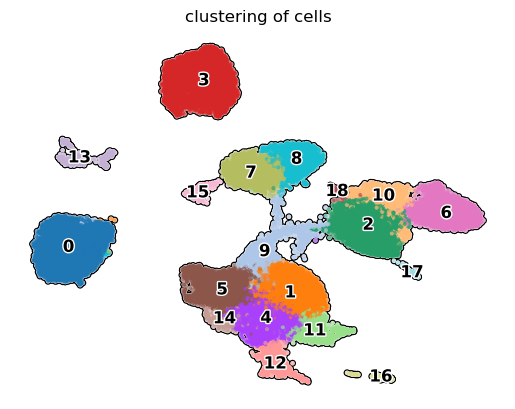

In [5]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, size=35,
           title='clustering of cells')

In [6]:
adata

AnnData object with n_obs × n_vars = 37079 × 4815
    obs: 'batch', 'doublet', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'hb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

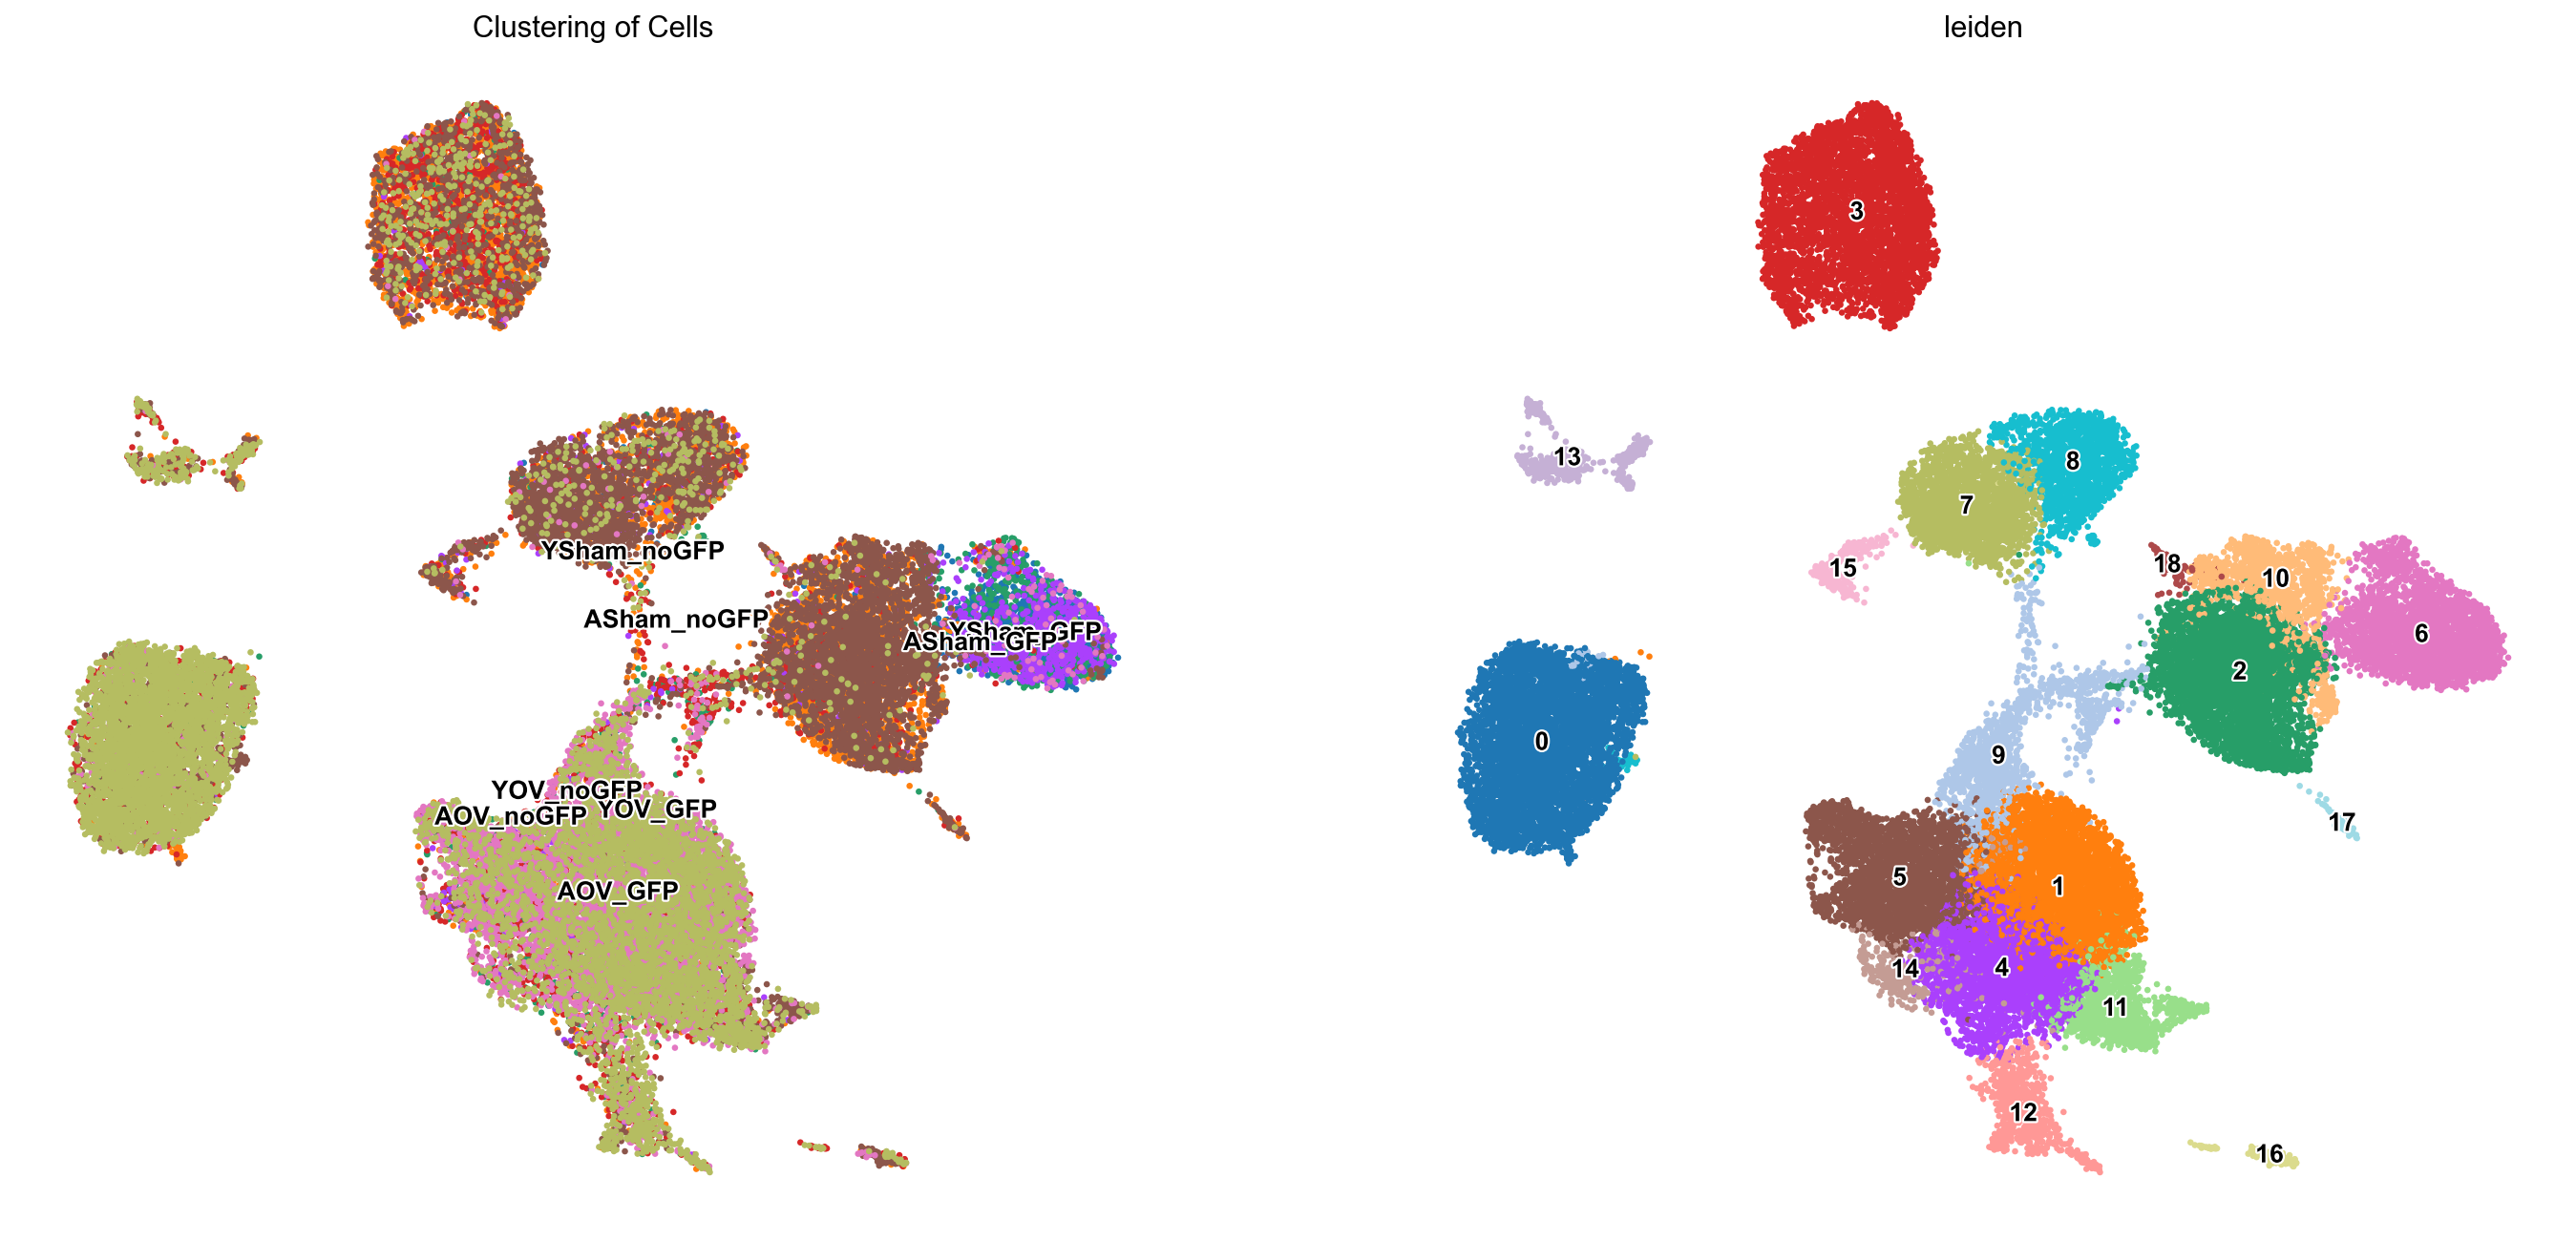

In [7]:
# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch', 'leiden'], legend_loc='on data', legend_fontsize=12, legend_fontoutline=2, frameon=False, size=35, title='Clustering of Cells', save=f'umap_plot after integration sample and cell type{img_tag}.png')
pl.show()

In [8]:

# Customize UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['batch'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=35, title='Clustering of Cells', save=f'umap_plot after intesample{img_tag}.png')
pl.show()

In [9]:
# Find marker genes for the refined clustering
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# View top marker genes
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save=f'rankgenese{img_tag}.png')

In [10]:
result=adata.uns['rank_genes_groups']
groups=result ['names'].dtype.names
df=pd.DataFrame(
    {group + '_' + key[:15]: result [key] [group]
     for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

In [11]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group    names      scores  logfoldchanges     pvals  pvals_adj
0          0     Srgn  113.792740        4.757599  0.000000   0.000000
1          0   S100a9  113.030037       10.741074  0.000000   0.000000
2          0   S100a8  110.732079        9.946331  0.000000   0.000000
3          0  S100a11  105.436470        3.715981  0.000000   0.000000
4          0   Tyrobp  105.193085        4.056935  0.000000   0.000000
...      ...      ...         ...             ...       ...        ...
702005    18    Ptov1    3.320741        1.754634  0.000898   0.048074
702006    18   Camk2d    3.320258        1.018602  0.000899   0.048091
702007    18   Olfml3    3.317071        2.334041  0.000910   0.048576
702008    18    Itga1    3.316060        2.125168  0.000913   0.048686
702009    18    Hspg2    3.310459        1.152499  0.000931   0.049602

[38907 rows x 6 columns]

In [12]:
# Create a DataFrame from the 'markers' variable
markers_df = pd.DataFrame(markers)

# Define the full path including the file name and extension
csv_file_path = 'P:/Tolulope/Manuscript/Yuan Analysis/markers_output.csv'

# Save the DataFrame to a CSV file
markers_df.to_csv(csv_file_path, index=False)

print(f"Output saved to {csv_file_path}")

Output saved to P:/Tolulope/Manuscript/Yuan Analysis/markers_output.csv


In [23]:
markers[markers.names =='']  

group   names    scores  logfoldchanges     pvals  pvals_adj
470143    12  Clec9a  4.627642        4.151556  0.000004   0.000048

In [24]:
cell_type = {
    "0": "Neutrophils",
    "1": "Lipid-Laden Macrophages",
    "2": "Fibroadipogenic cells I",
    "3": "Mature skeletal muscle",
    "4": "Residence Macrophages/APC",
    "5": "M2-like macrophages",
    "6": "MuSCs",
    "7": "Endothelial cells I",
    "8": "Endothelial cells II",
    "9": "Proliferation",
    "10": "Fibroadipogenic cells I", 
    "11": "Monocytes/Macrophages",
    "12": "Dendritic cells",
    "13": "T cells/NKCs",
    "14": "Interferons",
    "15": "Pericytes", 
    "16":  "Bcells",
    "17": "Tenocyte",
    "18": "Schwann cells",
     
        
}
# Now map the 'leiden_R' column to 'cell type'
adata.obs['cell type'] = adata.obs['leiden'].map(cell_type)


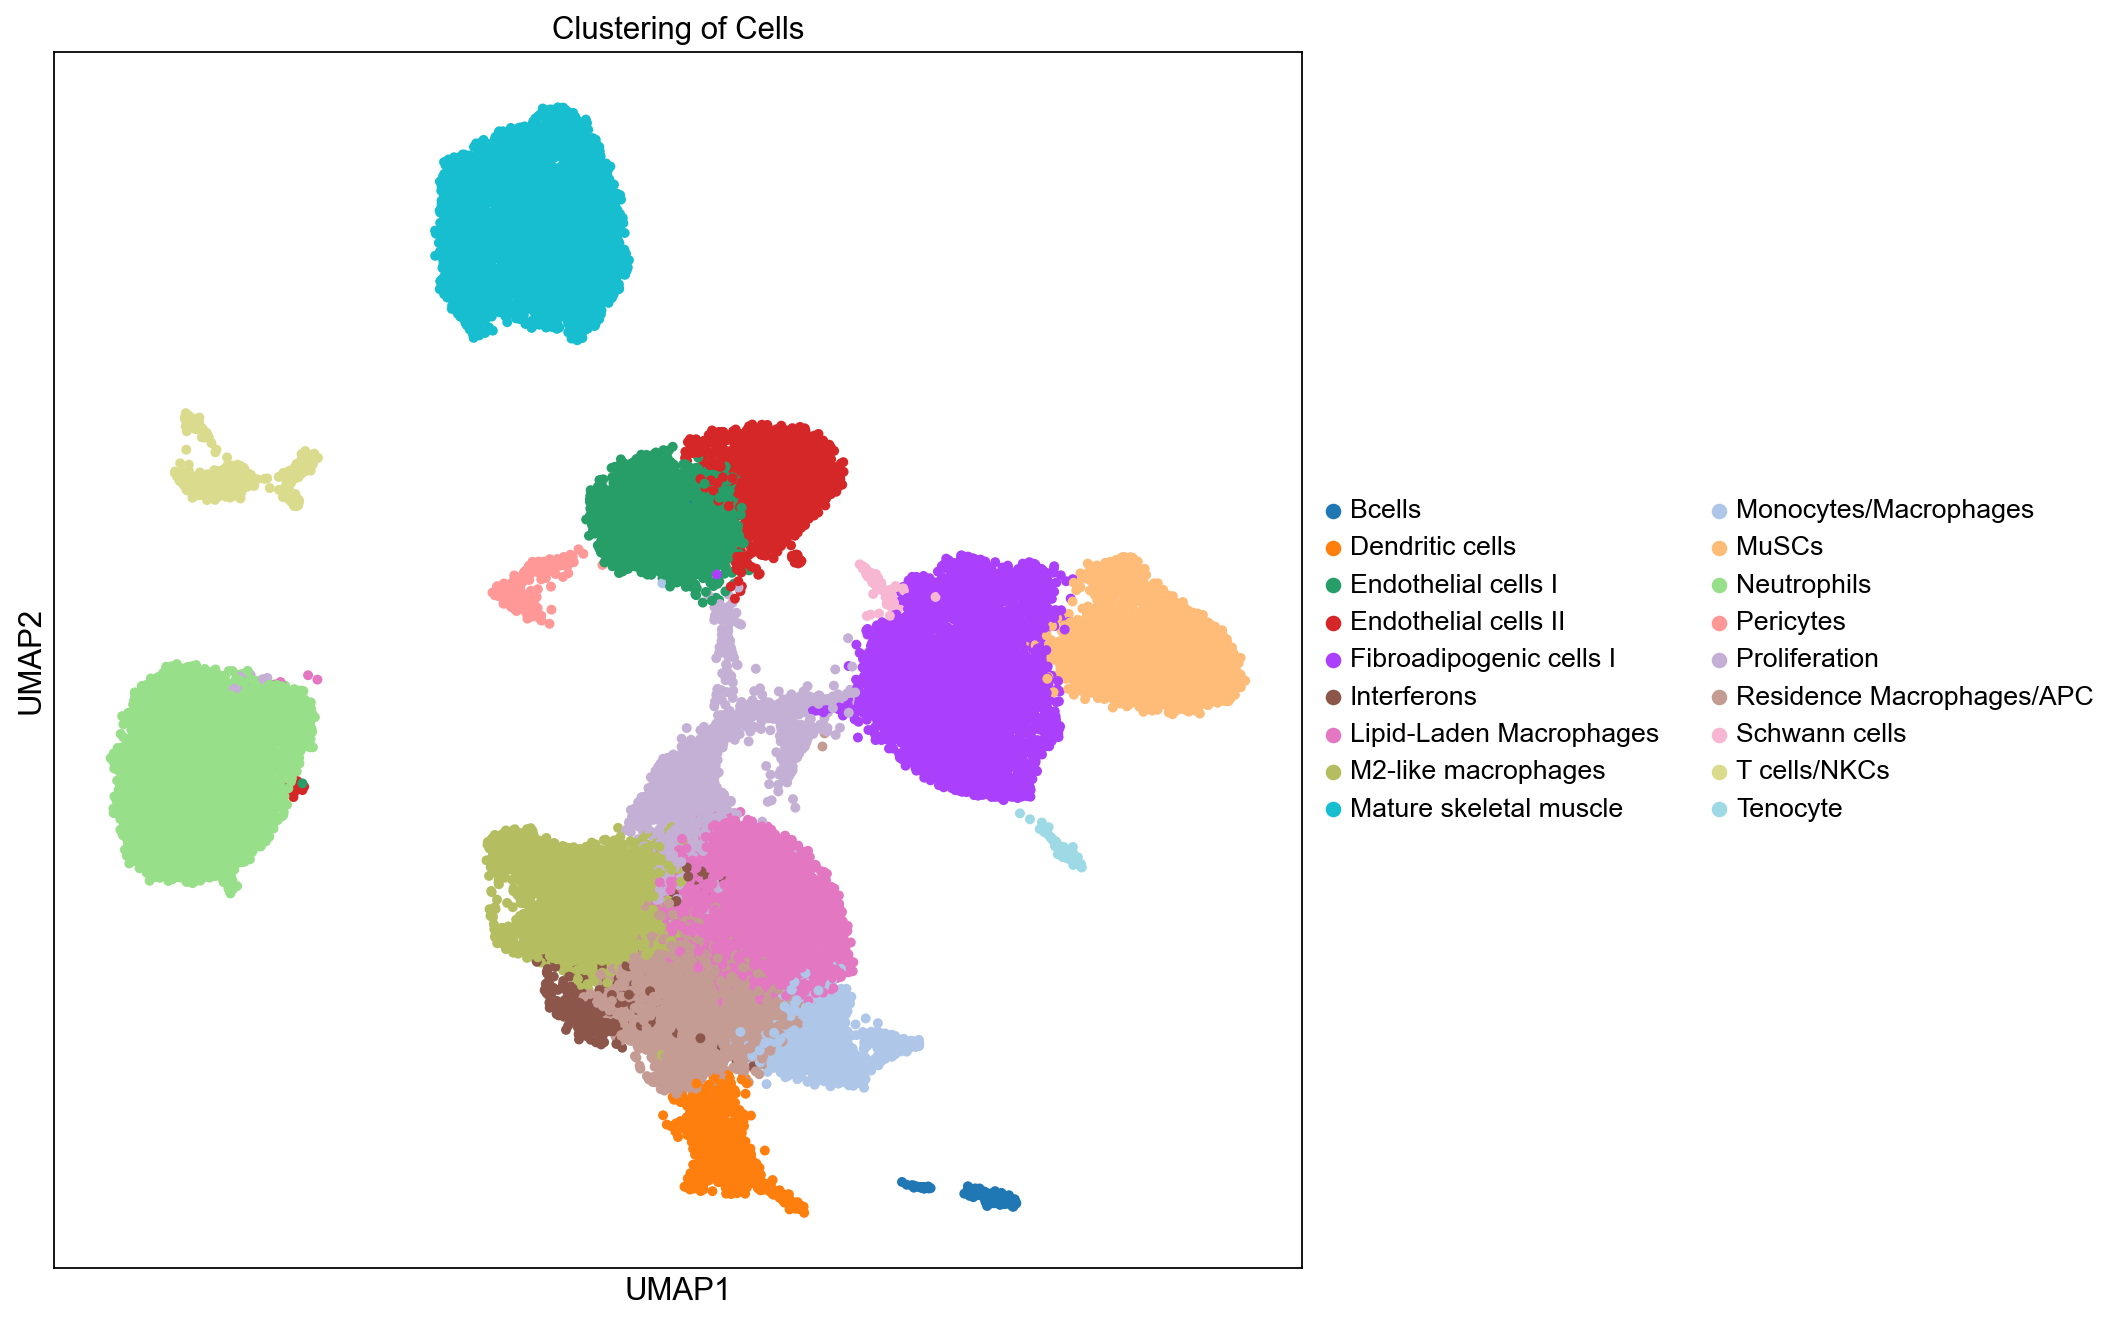

In [25]:
#UMAP plot
sc.set_figure_params(figsize=(10, 10))
img_tag = "_color"  # Specify your image tag here
sc.pl.umap(adata, color=['cell type'],  legend_fontsize=12, legend_fontoutline=2, frameon=True, size=80, title='Clustering of Cells', save=f'umap_plot{img_tag}.png')
pl.show()

In [26]:
adata.write_h5ad('integrated celltype ori.h5ad')

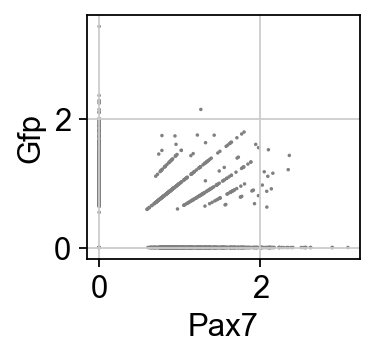

In [27]:
# Set figure size
pl.rcParams['figure.figsize'] = 3, 2

# Scatter plot of Pax7 vs Gfp and save it
sc.pl.scatter(adata, x="Pax7", y="Gfp", size=10, save=f"umap_correlation_{img_tag}.png")


In [28]:
adata_concat=adata.copy()

In [29]:
print(adata_concat.raw)
print(adata_concat.raw.var.shape)

Raw AnnData with n_obs × n_vars = 37079 × 38982
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'hb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
(38982, 14)


In [30]:
ad_filtered = adata_concat[((adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) & (adata_concat.raw[: , "Pax7"].X.toarray().flatten() ==0)), :].copy()
#ad_filtered = adata_concat[(adata_concat.raw[: , "Gfp"].X.toarray().flatten() ==0) , :].copy()
print(ad_filtered)

AnnData object with n_obs × n_vars = 35619 × 4815
    obs: 'batch', 'doublet', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'hb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'batch_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [31]:
sc.tl.embedding_density(ad_filtered, groupby='batch')

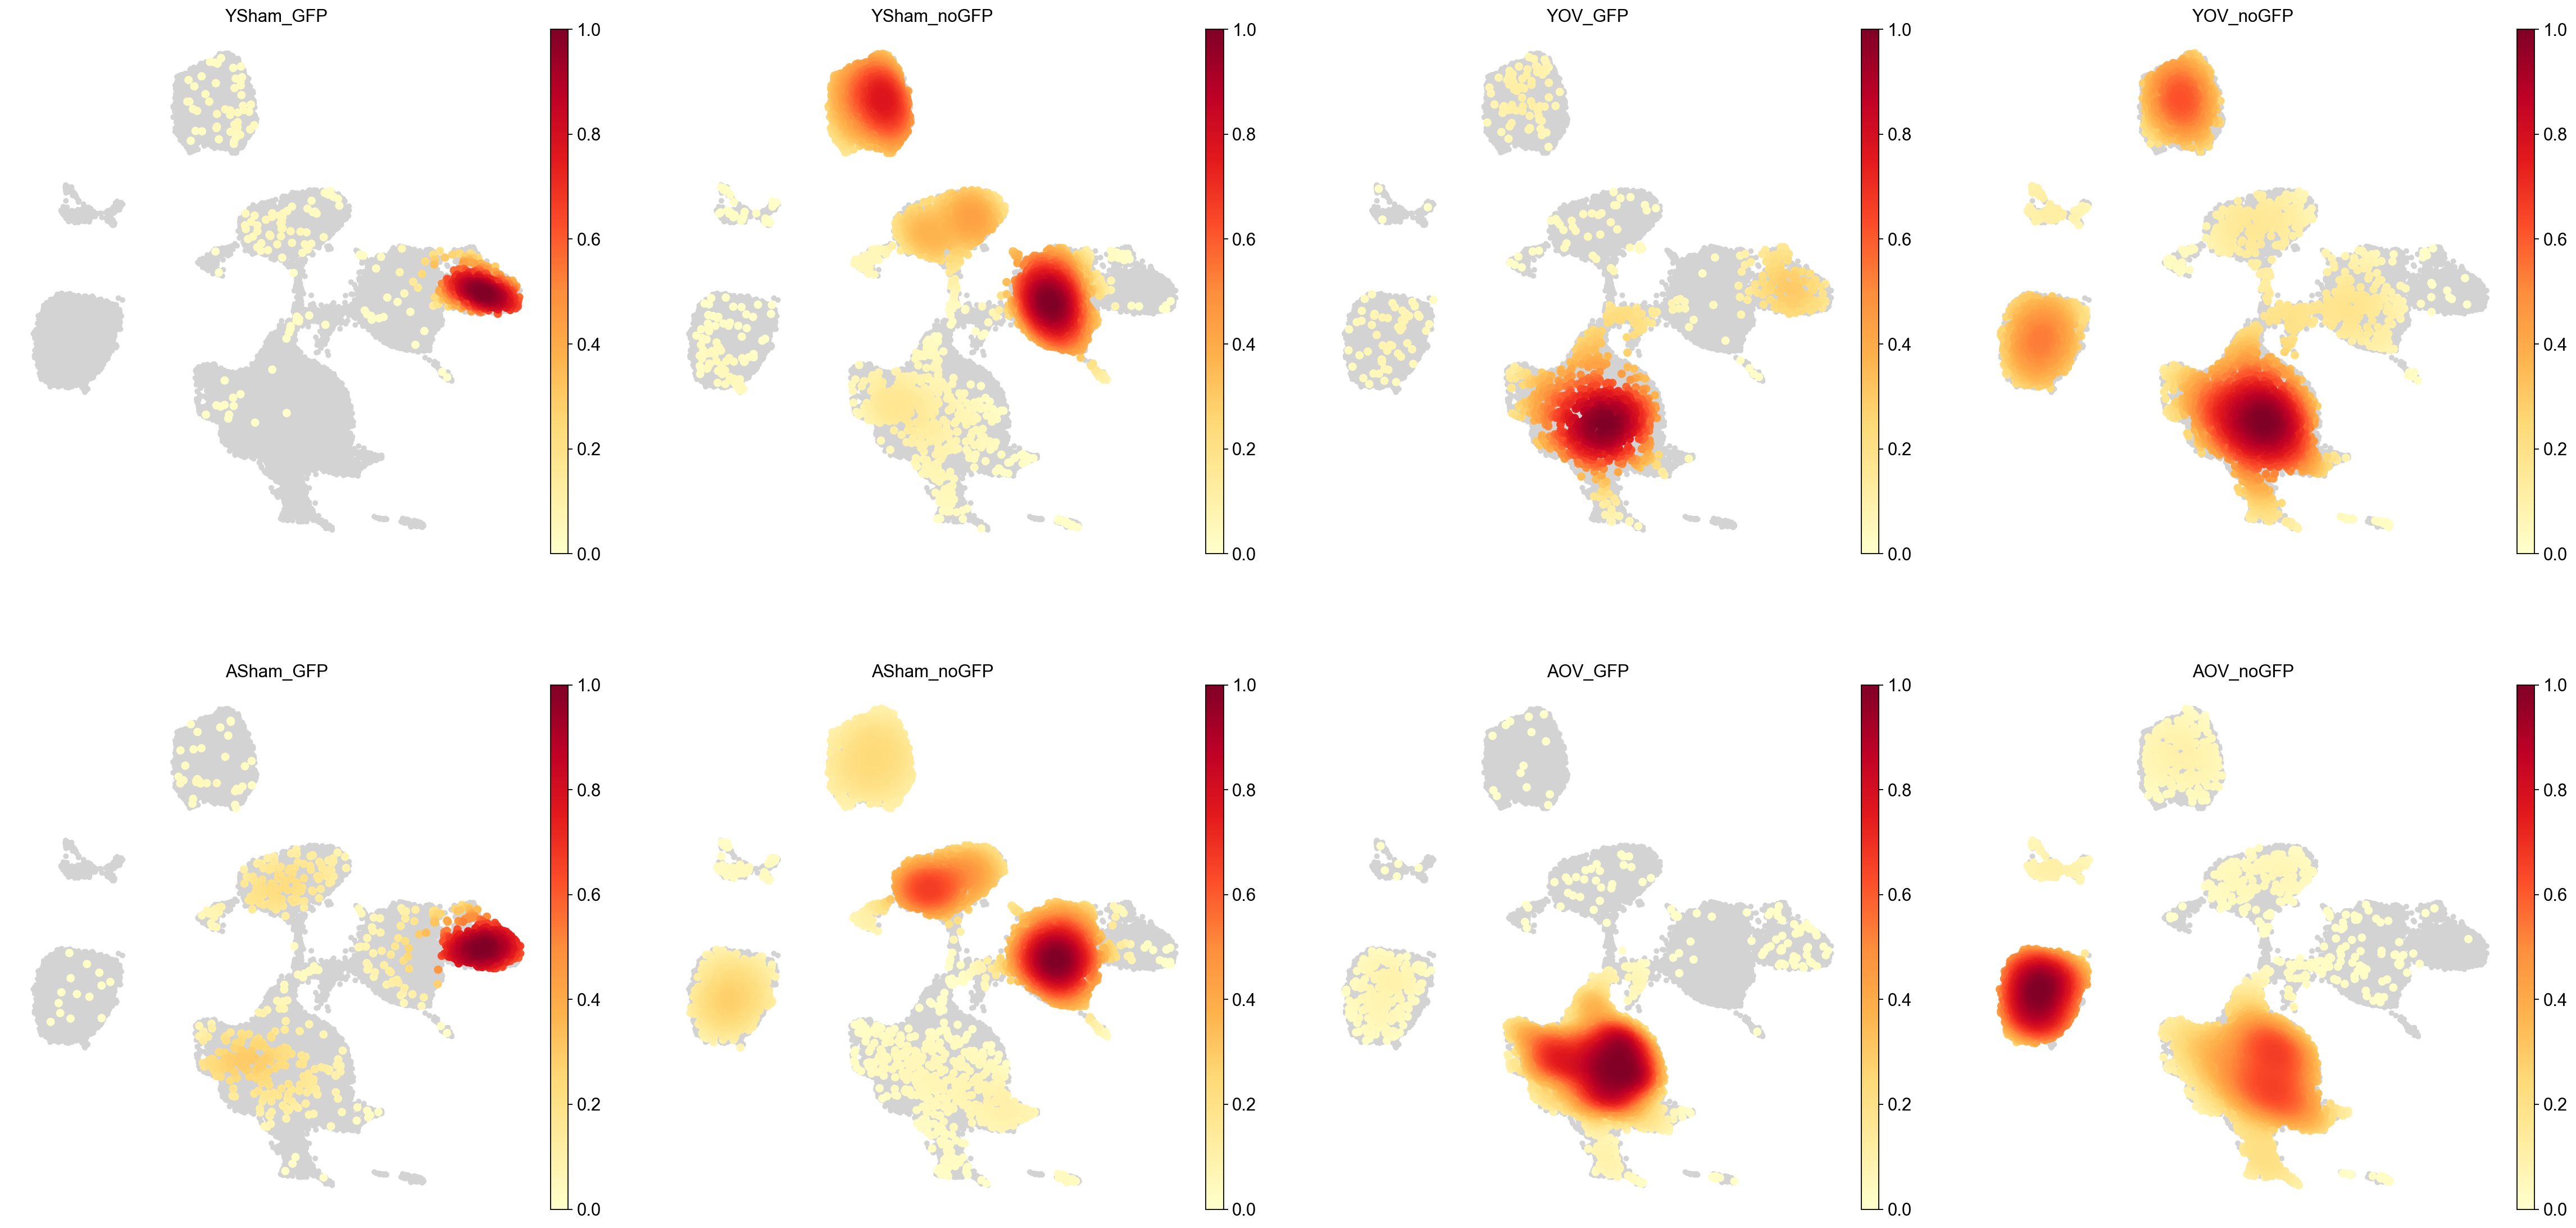

In [32]:
# Set figure size
pl.rcParams['figure.figsize'] = 8, 8
sc.pl.embedding_density(ad_filtered, groupby='batch',ncols=4,frameon=False)

In [33]:
ad_filtered.obs[['umap_density_batch','leiden','batch']].to_csv('density_by_cluster_filteredw2.csv')

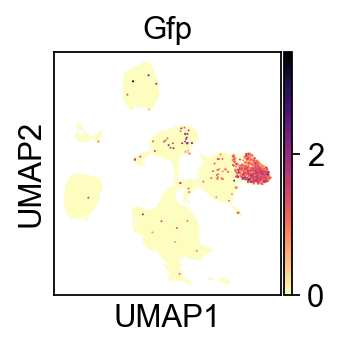

In [34]:
# Set figure size
pl.rcParams['figure.figsize'] = 2, 2

# Create the UMAP plot and save it
sc.pl.umap(adata, color='Gfp', color_map='magma_r', save=f"umap_Gfp_{img_tag}.png")

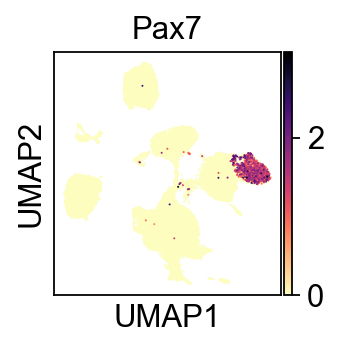

In [35]:
# Set figure size
pl.rcParams['figure.figsize'] = 2, 2

# Create the UMAP plot and save it
sc.pl.umap(adata, color='Pax7', color_map='magma_r', save=f"umap_Pax7_{img_tag}.png")

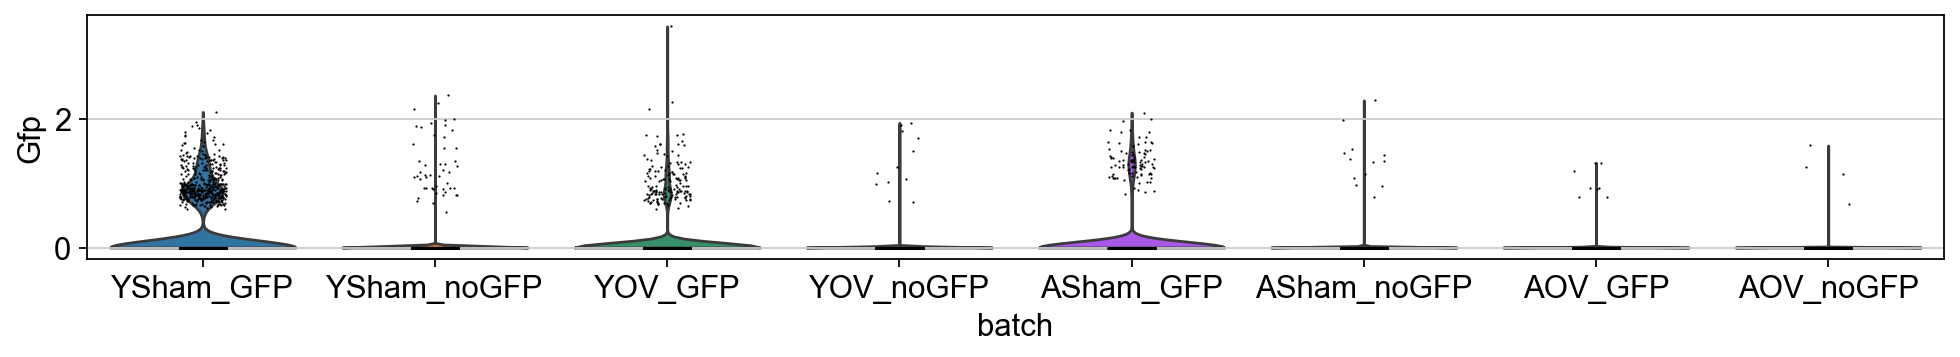

In [36]:
# Set figure size
pl.rcParams['figure.figsize'] = 12, 2

# Create violin plot
sc.pl.violin(adata, "Gfp", groupby="batch", save=f"umap_gfpviolin_{img_tag}.png")